### Crank-Nicolson implementation for the Black-Scholes equation.

On this first part of the pill we take a look at the integration of the solution of the Black-Scholes equation (PDE) using the Crank-Nicolson method. The code provided is an adaptation of the code avaiable in the following repository: https://github.com/antek0308/Volatility_notebooks/blob/main/Medium/Crank_Nicholson.ipynb.

In [1]:
# Import of libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [2]:
def CN_BS_Eq_call(K, T, sigma, r, Ns, Nt):
    """
    Crank-Nicolson scheme for the Black-Scholes equation (European call option)
    It integrates backwards in time from maturity t = T until present t = 0

    The function takes arguments:
        - K: the strick price
        - T: the maturity time
        - sigma: the percentage volatility
        - r: the risk-free interest rate
        - Ns: the number of price intervals (discretization)
        - Nt: the number of time invervals (discretization)

    The function returns:
        S: array of the present prices of the underlying
        V0: array of the price of the option at time t = 0
    """

    # Definition of the price (underlying) domain
    S_min = K / 3        # Minimum price s_0 (in the notes)
    S_max = 2 * K        # Maximum price s_{N_s} (in the notes)
    dS = (S_max - S_min) / Ns
    dt = T / Nt
    S = np.linspace(S_min, S_max, Ns + 1)  # Array of prices

    # Terminal condition, payoff of a European call option
    V = np.zeros((Ns + 1, Nt + 1))   # Array for the price of the option V_{i}^{j}
    V[:, -1] = np.maximum(S - K, 0)  # Payoff at maturity V_{i}^{N_t} = max(S-K, 0)

    # Boundary conditions (for all t)
    t_grid = np.linspace(0, T, Nt + 1)                # Time vector
    V[0, :] = 0.0                                     # Boundary condition i)
    V[-1, :] = S_max - K * np.exp(-r * (T - t_grid))  # Boundary condition ii)

    # Coefficients \alpha, \beta and \gamma of the linear system.
    Si = S
    alpha = 0.25 * dt * ((sigma**2) * (Si / dS)**2 - r * (Si / dS))
    beta  = -0.5 * dt * ((sigma**2) * (Si / dS)**2 + r)
    gamma = 0.25 * dt * ((sigma**2) * (Si / dS)**2 + r * (Si / dS))

    # Construction of the matricial representation of the system
    ML = sparse.diags(
        [-alpha[2:], 1 - beta[1:], -gamma[1:]],
        offsets=[-1, 0, 1],
        shape=(Ns - 1, Ns - 1)
    ).tocsc()

    MR = sparse.diags(
        [alpha[2:], 1 + beta[1:], gamma[1:]],
        offsets=[-1, 0, 1],
        shape=(Ns - 1, Ns - 1)
    ).tocsc()

    # Backwards integration in time
    for j in range(Nt - 1, -1, -1):
        # At each step we solve ML * V^j = MR * V^{j+1} +  contour terms
        # Border effect:
        boundary = np.zeros(Ns - 1)
        boundary[0]  = alpha[1] * (V[0, j] + V[0, j + 1])     # S = S_min
        boundary[-1] = gamma[Ns - 1] * (V[Ns, j] + V[Ns, j + 1])  # S = S_max

        # RHS
        b = MR.dot(V[1:Ns, j + 1]) + boundary

        # Solving the tridiagonal system in order to obtain V^j given V^{j+1}
        V[1:Ns, j] = spsolve(ML, b)

        # Fixing borders
        V[0, j] = 0.0
        V[Ns, j] = S_max - K * np.exp(-r * (T - t_grid[j]))

    # Return results
    V0 = V[:, 0]  # Option price at t=0
    return S, V0

Example of usage.

In [3]:
# Parameters
K=1        # Strike
T=1.0      # Maturity time
sigma=0.2  # Volatility
r=0.05     # Risk free interest rate
Ns=200     # Number of price intervals
Nt=400      # Number of time intervals

# We directly call the function using specific set of parameters.
S, V0 = CN_BS_Eq_call(K, T, sigma, r, Ns, Nt)

Graphical representation of the value of the integrated solution for the Euopean call option for different values the present underlying's price $s$.

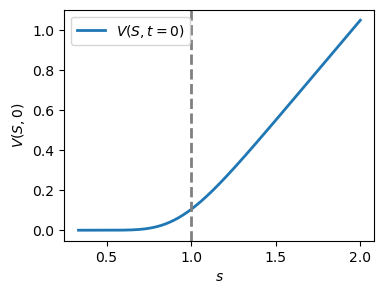

In [4]:
# --- Representación gráfica ---
plt.figure(figsize=(4,3))

plt.plot(S, V0, label=r'$V(S, t=0)$', lw=2)

# Additional
plt.axvline(1, color='gray', ls='--', lw=2) # The first argument

plt.xlabel(r'$s$')
plt.ylabel(r'$V(S,0)$')
plt.legend(loc='best')
plt.show()

### Application of the Feynman-Kac theorem.

As discussed in the **noted**, the direct application of the Feynman-Kac theorem to the BS equation returns the price of the option to be the discounted expected value of the payoff at maturity, and this is directly implemented by generating paths following geometric Brownian motion using now the risk--free interest rate,
\begin{align}
    dS_t = r S_t dt + \sigma S_t dW_{t}^{q} 
\end{align}
so that the solution to the BS equation is nothing but the discounted average payoff at maturity, i.e. for a European call option simply
\begin{align}
u(s,0) = e^{-rT} \mathbb{E}_q[\max{(S_T - K, 0)}|S_0 = s]. 
\end{align}
In order to do that, we proceed as done in the first chapter.

In [5]:
# Import of libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

We generate stochastic trajectories following geometric Brownian motion as done in the first chapter for differential initial prices, then compute the average payoff at maturity for fixed initial price $S_0$, and discount it.

In [6]:
# Parameters 
r = 0.05        # Risk free interest rate
sigma = 0.1     # Percentage volatility
K = 1           # Strike price

N = 10**5                            # Number of trajectories
T = 1.0                              # Maturity time
Nt = 1000                            # Number of time steps
dt = T / Nt                          # dt
t_grid = np.linspace(0, T, Nt + 1)   # time vector

We generate an array of initial underlying price.

In [7]:
S_0_list = np.linspace(K/3, 2*K, 20) # S_0 = K/3 to S_0 = 2K.

In [8]:
u_s_0 = [] # Keep here the values of the option prices at t = 0 for each s = s_0

for i, S_0 in enumerate(S_0_list):
    # Generation of trajectories
    x = np.zeros((N, Nt+1)) # Generating the arrows
    x[:,0] = S_0 # initial condition
    
    for t in range(1,Nt+1):
        x[:,t] = x[:,t-1] * (1 + dt * r + sigma * np.random.normal(0, np.sqrt(dt), size=N))

    # Definition of u(s,t)
    x_T = x[:,-1]
    payoff = np.maximum(x_T-K,0)
    avg_payoff = np.mean(payoff, axis=0)
    u_0 = np.exp(-r*T)*avg_payoff
    u_s_0.append(u_0)
    print(f"{i+1}/{len(S_0_list)} done ...")

1/20 done ...
2/20 done ...
3/20 done ...
4/20 done ...
5/20 done ...
6/20 done ...
7/20 done ...
8/20 done ...
9/20 done ...
10/20 done ...
11/20 done ...
12/20 done ...
13/20 done ...
14/20 done ...
15/20 done ...
16/20 done ...
17/20 done ...
18/20 done ...
19/20 done ...
20/20 done ...


Graphical representation of the simulated values of the option's price at present (using GBM).

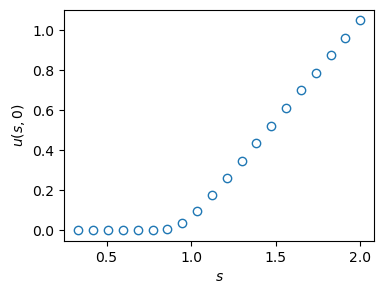

In [9]:
plt.figure(figsize=(4,3))

plt.plot(S_0_list, u_s_0, marker = 'o', markerfacecolor='none', linestyle = 'none')

plt.xlabel(r'$s$')
plt.ylabel(r'$u(s,0)$')
plt.show()

Same plot but now inlcuding both the numerical integration of the BS equation for the same parameter set and also the analytical solution of the BS equation.

In [10]:
# Analytical solution
def BSM_European_Call(S_0, K, r, sigma, T): # From last chapter's pill
    d1 =  (1/(sigma * np.sqrt(T))) * (np.log(S_0/K) + (r + 0.5 * sigma ** 2) * T)
    d2 = d1 - sigma * np.sqrt(T) 
    return S_0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

In [11]:
S_range = np.linspace(K/3, 2*K, 100)
c_bsm = BSM_European_Call(S_range, K, r, sigma, T)

The integration of the BS equation, using the function defined in the first section of the pill.

In [12]:
# Parameters
K=1        # Strike
T=1.0      # Maturity time
sigma=0.2  # Volatility
r=0.05     # Risk free interest rate
Ns=200     # Number of price intervals
Nt=400      # Number of time intervals

# We directly call the function using specific set of parameters.
S, V0 = CN_BS_Eq_call(K, T, sigma, r, Ns, Nt)

The plot

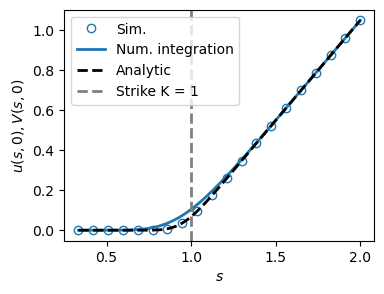

In [14]:
# Figure size
plt.figure(figsize=(4,3))

plt.plot(S_0_list, u_s_0, marker = 'o', markerfacecolor='none', linestyle = 'none', label = r'Sim.')
plt.plot(S, V0, lw=2, label = r'Num. integration', color = 'tab:blue')
plt.plot(S_range, c_bsm, lw = 2, linestyle = '--', color = 'black', label = r'Analytic')

# Additional
plt.axvline(K, color='gray', ls='--', lw=2, label = f'Strike K = {K}')

plt.xlabel('$s$')
plt.ylabel(r'$u(s,0), V(s,0)$')
plt.legend(loc='best')
plt.savefig('simulated_vs_cn_vs_analytical.pdf', bbox_inches='tight')
plt.show()